In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%writefile visual.py
""" plot and save to gcs """
from matplotlib import pyplot as plt
from google.cloud import storage

def save_fig(filename, path, gcs):
    """ save current plt fig to gcs """
    plt.gcf().savefig(filename)
    plt.close()
    # init GCS client and upload file
    client = storage.Client()
    bucket = client.get_bucket(gcs)
    blob = bucket.blob(f'{path}/{filename}')
    blob.upload_from_filename(filename=filename)


def plot_history(history, path, bucket):
    """ plot a save the model's history """
    ## Eval
    _, axs = plt.subplots(1, 2, figsize=(18, 4))
    # Plot training & validation loss values
    ax = axs[0]
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_yscale('log')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Test'], loc='lower left')

#     # Plot training & validation accuracy values
#     ax = axs[1]
#     ax.plot(history.history['accuracy'])
#     ax.plot(history.history['val_accuracy'])
#     ax.set_title('Model accuracy')
#     ax.set_ylabel('Accuracy')
#     ax.set_xlabel('Epoch')
#     ax.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation accuracy values
    ax = axs[1]
    ax.plot(history.history['auc'])
    ax.plot(history.history['val_auc'])
    ax.set_title('Model AUC')
    ax.set_ylabel('AUC')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Test'], loc='upper left')

    save_fig('history.png', path, bucket)

Overwriting visual.py


In [10]:
!pylint3 visual.py --ignored-modules=tensorflow.keras

No config file found, using default configuration
************* Module visual
C: 21, 4: Variable name "ax" doesn't conform to snake_case naming style (invalid-name)
C: 40, 4: Variable name "ax" doesn't conform to snake_case naming style (invalid-name)

-----------------------------------
Your code has been rated at 9.26/10



In [3]:
%%writefile focal_loss.py
""" binary focal loss with label_smoothing """
import tensorflow as tf
from tensorflow.keras import backend as K


def focal_loss(gamma=2., pos_weight=1, label_smoothing=0.05):
    """ binary focal loss with label_smoothing """
    def binary_focal_loss(labels, p):
        """ bfl clojure """
        labels = tf.dtypes.cast(labels, dtype=p.dtype)
        if label_smoothing is not None:
            labels = (1 - label_smoothing) * labels + label_smoothing * 0.5

        # Predicted probabilities for the negative class
        q = 1 - p

        # For numerical stability (so we don't inadvertently take the log of 0)
        p = tf.math.maximum(p, K.epsilon())
        q = tf.math.maximum(q, K.epsilon())

        # Loss for the positive examples
        pos_loss = -(q ** gamma) * tf.math.log(p) * pos_weight

        # Loss for the negative examples
        neg_loss = -(p ** gamma) * tf.math.log(q)

        # Combine loss terms
        loss = labels * pos_loss + (1 - labels) * neg_loss

        return loss

    return binary_focal_loss

Overwriting focal_loss.py


In [ ]:
!pylint3 focal_loss.py --ignored-modules=tensorflow.keras

In [4]:
%%writefile single_model.py
""" build a TFAutoModel and load its data from npz or tfrec dataset """
import os
import gc
import time
import random

import logging
import numpy as np
import pandas as pd
# from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score

import tensorflow_addons as tfa
# from tensorflow_addons.optimizers.utils import fit_bn

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model

from transformers import TFAutoModel

from one_cycle_scheduler import OneCycleScheduler
from focal_loss import focal_loss

logging.getLogger('tensorflow').setLevel(logging.ERROR)


def build_model(model_id='jplu/tf-xlm-roberta-large',
                max_len=192, dropout=0.2,
                **_):
    """ build a TFAutoModel """
    transformer = TFAutoModel.from_pretrained(model_id)

    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    if dropout > 0:
        cls_token = Dropout(dropout)(cls_token)
    out = Dense(1, activation='sigmoid')(cls_token)
    model = Model(inputs=input_word_ids, outputs=out)

    return model



def np_dataset(dataset, batch_size, seed):
    """ load npz datasets """
    array = np.load(dataset)
    x_train, x_valid, x_test, y_train, y_valid = [array[k] for k in list(array)]
    # Shuffle
    x_train = pd.DataFrame(np.concatenate([x_train.T, [y_train]]).T
                          ).sample(frac=1, random_state=seed).values
    assert abs(x_train[..., :-1] - x_train[..., :-1].astype('int32')).max() == 0
    x_train, y_train = x_train[..., :-1].astype('int32'), x_train[..., -1].astype('float32')
    print(x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape)

    ## Set Datasets
    auto_tune = tf.data.experimental.AUTOTUNE
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((x_train, y_train))
        .repeat()
        .shuffle(2048)
        .batch(batch_size)
        .prefetch(auto_tune)
    )

    valid_dataset = (
        tf.data.Dataset
        .from_tensor_slices((x_valid, y_valid))
        .batch(batch_size)
        .cache()
        .prefetch(auto_tune)
    )

    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(x_test)
        .batch(batch_size)
        .prefetch(auto_tune)
    )

    return train_dataset, valid_dataset, test_dataset


def val_np_dataset(dataset='../input/jigsaw20-val-test-ds/jigsaw20_val_ds.npz', batch_size=128):
    """ load npz datasets """
    array = np.load(dataset)
    x_valid, x_test, y_valid = [array[k] for k in list(array)]
    print(x_valid.shape, x_test.shape, y_valid.shape)

    ## Set Datasets
    auto_tune = tf.data.experimental.AUTOTUNE
    valid_dataset = (
        tf.data.Dataset
        .from_tensor_slices((x_valid, y_valid))
        .batch(batch_size)
        .cache()
        .prefetch(auto_tune)
    )

    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(x_test)
        .batch(batch_size)
        .prefetch(auto_tune)
    )

    return valid_dataset, test_dataset


def tf_dataset(dataset, batch_size, max_len, seed):
    """ load tfrec datasets """
    auto_tune = tf.data.experimental.AUTOTUNE

    train_dataset = (
        load_tf_dataset(dataset+'train*.tfrec', max_len, seed)
        .repeat()
        .shuffle(2048)
        .batch(batch_size)
        .prefetch(auto_tune)
    )

    valid_dataset, test_dataset = val_np_dataset(batch_size=batch_size)

    return train_dataset, valid_dataset, test_dataset

def load_tf_dataset(filenames, max_len, seed, ordered=False):
    """ load a tfrec dataset """
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
    auto_tune = tf.data.experimental.AUTOTUNE

    def read_labeled_tfrecord(example, max_len=max_len):
        """ decode a tfrec """
        tf_format = {
            "data": tf.io.FixedLenFeature(max_len, tf.int64),
            "label": tf.io.FixedLenFeature([], tf.float32),  # shape [] means single element
        }
        example = tf.io.parse_single_example(example, tf_format)
        return example['data'], example['label']

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    # expand and shuffle files
    filenames = tf.io.gfile.glob(filenames)
    random.Random(seed).shuffle(filenames)
    # automatically interleaves reads from multiple files
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=auto_tune)
    # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=auto_tune)
    return dataset


Overwriting single_model.py


In [ ]:
!pylint3 single_model.py --ignored-modules=tensorflow.keras

In [ ]:
%%writefile dual_model.py
""" build a dual TFAutoModel and load its data from npz or tfrec dataset """
import os
import gc
import time
import random

import logging
import numpy as np
import pandas as pd
# from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score

import tensorflow_addons as tfa
# from tensorflow_addons.optimizers.utils import fit_bn

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model

from transformers import TFAutoModel

from one_cycle_scheduler import OneCycleScheduler
from focal_loss import focal_loss

logging.getLogger('tensorflow').setLevel(logging.ERROR)


def build_model(model_id1='bert-base-multilingual-uncased',
                model_id2='bert-base-multilingual-cased',
                max_len=192, dropout=0.2,
                **_):
    """ build a dual TFAutoModel """
    transformer1_layer = TFAutoModel.from_pretrained(model_id1)
    transformer2_layer = TFAutoModel.from_pretrained(model_id2)
    
    input_word_ids1 = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids1")
    out1 = transformer1(input_word_ids1)
    
    input_word_ids2 = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids2")
    out2 = transformer2(input_word_ids2)
    
    sequence_output1 = out1[0]
    sequence_output2 = out2[0]
    cls_token1 = sequence_output1[:, 0, :]
    cls_token2 = sequence_output2[:, 0, :]
    
    x = Dropout(dropout)(cls_token1) + Dropout(dropout)(cls_token2)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[input_word_ids1, input_word_ids2], outputs=out)

    return model



def np_dataset(dataset, batch_size, seed):
    """ load npz datasets """
    array = np.load(dataset)
    x_train, x_valid, x_test, y_train, y_valid = [array[k] for k in list(array)]
    # Shuffle
    x_train = pd.DataFrame(np.concatenate([x_train.T, [y_train]]).T
                          ).sample(frac=1, random_state=seed).values
    assert abs(x_train[..., :-1] - x_train[..., :-1].astype('int32')).max() == 0
    x_train, y_train = x_train[..., :-1].astype('int32'), x_train[..., -1].astype('float32')
    print(x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape)

    ## Set Datasets
    auto_tune = tf.data.experimental.AUTOTUNE
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((x_train, y_train))
        .repeat()
        .shuffle(2048)
        .batch(batch_size)
        .prefetch(auto_tune)
    )

    valid_dataset = (
        tf.data.Dataset
        .from_tensor_slices((x_valid, y_valid))
        .batch(batch_size)
        .cache()
        .prefetch(auto_tune)
    )

    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(x_test)
        .batch(batch_size)
        .prefetch(auto_tune)
    )

    return train_dataset, valid_dataset, test_dataset


def val_np_dataset(dataset='../input/jigsaw20-val-test-ds/jigsaw20_val_ds.npz', batch_size=128):
    """ load npz datasets """
    array = np.load(dataset)
    x_valid, x_test, y_valid = [array[k] for k in list(array)]
    print(x_valid.shape, x_test.shape, y_valid.shape)

    ## Set Datasets
    auto_tune = tf.data.experimental.AUTOTUNE
    valid_dataset = (
        tf.data.Dataset
        .from_tensor_slices((x_valid, y_valid))
        .batch(batch_size)
        .cache()
        .prefetch(auto_tune)
    )

    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(x_test)
        .batch(batch_size)
        .prefetch(auto_tune)
    )

    return valid_dataset, test_dataset


def tf_dataset(dataset, batch_size, max_len, seed):
    """ load tfrec datasets """
    auto_tune = tf.data.experimental.AUTOTUNE

    train_dataset = (
        load_tf_dataset(dataset+'train*.tfrec', max_len, seed)
        .repeat()
        .shuffle(2048)
        .batch(batch_size)
        .prefetch(auto_tune)
    )

    valid_dataset, test_dataset = val_np_dataset(batch_size=batch_size)

    return train_dataset, valid_dataset, test_dataset

def load_tf_dataset(filenames, max_len, seed, ordered=False):
    """ load a tfrec dataset """
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
    auto_tune = tf.data.experimental.AUTOTUNE

    def read_labeled_tfrecord(example, max_len=max_len):
        """ decode a tfrec """
        tf_format = {
            "data": tf.io.FixedLenFeature(max_len, tf.int64),
            "label": tf.io.FixedLenFeature([], tf.float32),  # shape [] means single element
        }
        example = tf.io.parse_single_example(example, tf_format)
        return example['data'], example['label']

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    # expand and shuffle files
    filenames = tf.io.gfile.glob(filenames)
    random.Random(seed).shuffle(filenames)
    # automatically interleaves reads from multiple files
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=auto_tune)
    # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=auto_tune)
    return dataset


In [5]:
%%writefile train.py
""" build and train a TFAutoModel from npz or tfrec dataset """
import os
import gc
import time
import random

import logging
import numpy as np
import pandas as pd
# from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

import tensorflow_addons as tfa
# from tensorflow_addons.optimizers.utils import fit_bn

import tensorflow as tf

from one_cycle_scheduler import OneCycleScheduler
from single_model import build_model, tf_dataset, np_dataset
from visual import save_fig, plot_history

logging.getLogger('tensorflow').setLevel(logging.ERROR)


def compile(model,
            optimizer='LAMB', lr=2e-5, weight_decay=1e-6,
            loss_fn='bce', label_smoothing=0.01,
            pos_weight=5, gamma=2.0,  ## focal loss
            amp=False,
            **_):
    """ compile the model with a loss function and an optimizer """
    if loss_fn == 'focal':
        loss = focal_loss(pos_weight=pos_weight, gamma=gamma, label_smoothing=label_smoothing)
    elif loss_fn == 'bce':
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)

    if optimizer == 'LAMB':
        opt = tfa.optimizers.LAMB(lr=lr, weight_decay_rate=weight_decay)
    elif optimizer == 'AdamW':
        opt = tfa.optimizers.AdamW(lr=lr, weight_decay=weight_decay)
    print(opt)

    if amp:
        print('Using auto_mixed_precision.')
        tf.config.optimizer.set_jit(True)
        tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
        opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt, 'dynamic')

    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )

    return model



def train_model(model, strategy, checkpoint_path,
                dataset, max_len=192, seed=0,
                epochs=30, steps_per_epoch=250,
                lr=2e-5, one_cycle=True, warm_up=1,
                mom_min=0.85, mom_max=0.95,
                div_factor=100, final_div_factor=250,
                batch_size=28, callback=None,
                **_):
    """ train the given model """
    batch_size = batch_size * strategy.num_replicas_in_sync
    print('batch_size:', batch_size)

    if dataset.startswith('gs://'):
        train_dataset, valid_dataset, test_dataset = tf_dataset(dataset, batch_size, max_len, seed)
    else:
        train_dataset, valid_dataset, test_dataset = np_dataset(dataset, batch_size, seed)

    ## Train
    callbacks = [] if callback is None else [callback]
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=1e-4,
                                                      mode='max', patience=epochs//5, verbose=1,
                                                      restore_best_weights=False)) # restore later

    if one_cycle:
        callbacks.append(OneCycleScheduler(lr_max=lr, steps=steps_per_epoch*epochs,
                                           mom_min=mom_min, mom_max=mom_max,
                                           phase_1_pct=warm_up/epochs,
                                           div_factor=div_factor,
                                           final_div_factor=final_div_factor))
    else:
        callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.31,
                                                              patience=2, cooldown=1, mode='max',
                                                              verbose=1, min_delta=1e-4))

    callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        monitor='val_auc',
                                                        verbose=1, mode='max',
                                                        save_best_only=True,
                                                        save_weights_only=True))
    print(callbacks)

    model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_dataset,
        epochs=epochs,
        callbacks=callbacks,
    )

    # load best
    if epochs > 1:
        # latest = tf.train.latest_checkpoint(checkpoint_dir)
        with strategy.scope():
            model.load_weights(checkpoint_path)

    return (model,
            model.predict(valid_dataset, verbose=1),
            model.predict(test_dataset, verbose=1))



def setup_tpu(tpu_id):
    """ resolve a tpu cluster """
    if tpu_id is None:
        with open('tpu', 'r') as content_file:
            tpu_id = content_file.read()
            print(dict(tpu_id=tpu_id))

    ## Detect hardware, return appropriate distribution strategy
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is
        # set: this is always the case on Kaggle.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_id)
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()
    print("REPLICAS: ", strategy.num_replicas_in_sync)
    return strategy



##################
###### MAIN ######
##################

def train(gcs='hm-eu-w4', path='jigsaw/test',
          seed=0, max_len=192, tpu_id=None,
          **kwargs):
    """ build and train a TFAutoModel from npz or tfrec dataset """
    params = dict(locals())
    params.update(kwargs)
    params = pd.DataFrame(params, index=[0])
    del params['kwargs']
    if params.loc[0, 'loss_fn'] != 'focal':
        del params['gamma']
        del params['pos_weight']
    kw_params = params.T[0].to_dict()
    print(params.T)
    gc.collect()

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    strategy = setup_tpu(tpu_id)

    ## Configuration
    path = f'{path}/{time.strftime("%Y%m%d_%H%M%S")}_{tpu_id}'
    gcs_path = f'gs://{gcs}/{path}'
    checkpoint_path = f"{gcs_path}/best_model.tf"
    print('gcs_path:', gcs_path)
    params['gcs_path'] = gcs_path

    ## Load and Train
    with strategy.scope():
        model = build_model(**kw_params)
        model = compile(model, **kw_params)
    model, preds, sub_y = train_model(model, strategy, checkpoint_path, **kw_params)

    ## Save results
    plot_history(model.history, path, gcs)
    history = pd.DataFrame(model.history.history)
    print(history)
    history.to_csv(f'{gcs_path}/history.csv', index=False)

    ## Load Dataset
    comp_ds = '../input/jigsaw-multilingual-toxic-comment-classification'
    valid = pd.read_csv(f'{comp_ds}/validation.csv')
#     test = pd.read_csv(f'{comp_ds}/test.csv')
    sub = pd.read_csv(f'{comp_ds}/sample_submission.csv')

    valid['pred'] = preds
    valid.to_csv(f'{gcs_path}/valid_oof.csv', index=False)

    valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.5)
    plt.legend([0, 1])
    save_fig('valid_hist.png', path, gcs)

    valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.34)
    plt.legend(valid.lang.unique())
    save_fig('valid_toxic_hist.png', path, gcs)

    valid_auc = roc_auc_score(valid.toxic, valid.pred)
    print('AUC:', valid_auc,
          'toxic:', valid.toxic.mean(),
          'pred:', valid.pred.mean(),
          'ratio:', (valid.pred > 0.5).mean())

    ## Submission
    sub['toxic'] = sub_y
    sub.to_csv(f'{gcs_path}/submission.csv', index=False)

    sub.toxic.hist(bins=100, log=True)
    save_fig('sub_hist.png', path, gcs)
    print('mean:', sub.toxic.mean(), 'ratio:', (sub.toxic > 0.5).mean())

    ## Save params
    params['auc'] = valid_auc
    params.to_csv(f'{gcs_path}/params{valid_auc:04f}.csv', index=False)
    print(params.T)

    return valid_auc

Overwriting train.py


In [6]:
!pylint3 train.py --ignored-modules=tensorflow.keras

No config file found, using default configuration
************* Module train
W: 26, 0: Redefining built-in 'compile' (redefined-builtin)
W: 20, 0: Wildcard import single_model (wildcard-import)
C: 26, 0: Argument name "lr" doesn't conform to snake_case naming style (invalid-name)
R: 26, 0: Too many arguments (9/5) (too-many-arguments)
C: 60, 0: Argument name "lr" doesn't conform to snake_case naming style (invalid-name)
R: 60, 0: Too many arguments (17/5) (too-many-arguments)
R: 60, 0: Too many local variables (22/15) (too-many-locals)
R:153, 0: Too many local variables (19/15) (too-many-locals)
W:154,18: Unused argument 'max_len' (unused-argument)
R:153, 0: Too many statements (51/50) (too-many-statements)
W: 20, 0: Unused import val_np_dataset from wildcard import (unused-wildcard-import)
W: 20, 0: Unused import load_tf_dataset from wildcard import (unused-wildcard-import)
W: 20, 0: Unused import K from wildcard import (unused-wildcard-import)
W: 20, 0: Unused import Dense from wildc

In [7]:
import numpy as np
from train import train

best = (0, None)

for i in range(1):
    params = dict(
        optimizer=np.random.choice(['LAMB', 'AdamW']),
        lr=10**np.random.uniform(low=-5.5, high=-4),
        weight_decay=10**np.random.uniform(low=-6.5, high=-4.5),
        loss_fn='focal',
        label_smoothing=np.random.uniform(low=0.01, high=0.04),
        pos_weight=np.random.uniform(low=1.5, high=5),
        gamma=np.random.uniform(low=1.0, high=2.5),
        warm_up=np.random.uniform(low=1, high=5),
        epochs=1, #np.random.randint(low=28, high=38),
        steps_per_epoch=5,
        batch_size=8,
        amp=False,
        dataset='gs://hm-eu-w4/jigsaw/translated-distilled-ds4/',
        path=f'jigsaw/test',
        tpu_id='t8a',
        seed=np.random.randint(99),
    )

    auc = train(**params)
    if auc > best[0]:
        best = (auc, i, params)
        print('Best params:', best)

print('### Grid Search Done:')
print(best)

                                                              0
tpu_id                                                      t8a
max_len                                                     192
seed                                                         24
path                                                jigsaw/test
gcs                                                    hm-eu-w4
optimizer                                                 AdamW
lr                                                   9.4322e-06
weight_decay                                         3.0273e-05
loss_fn                                                   focal
label_smoothing                                       0.0343972
pos_weight                                              4.15313
gamma                                                   1.96506
warm_up                                                 4.71866
epochs                                                        1
steps_per_epoch                         

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


REPLICAS:  8
gcs_path: gs://hm-eu-w4/jigsaw/test/20200503_084941_t8a
batch_size: 64
(8000, 192) (63812, 192) (8000,)
[<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7f0f9f2f0be0>, <one_cycle_scheduler.OneCycleScheduler object at 0x7f0e9856aa58>, <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7f0e9846a0f0>]
Train for 5 steps, validate for 125 steps


/home/henrique/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)
/home/henrique/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


4/5 [=======================>......] - ETA: 50s - loss: 0.3019 - auc: 0.6574 
Epoch 00001: val_auc improved from -inf to 0.50005, saving model to gs://hm-eu-w4/jigsaw/test/20200503_084941_t8a/best_model.tf
998/998 [==============================] - 110s 110ms/step
       loss       auc  val_loss   val_auc
0  0.299952  0.577405  0.271884  0.500055
AUC: 0.5004360461625296 toxic: 0.15375 pred: 0.49188647 ratio: 0.298125
mean: 0.49824515 ratio: 0.4568263022628973
                                                              0
tpu_id                                                      t8a
max_len                                                     192
seed                                                         24
path                                                jigsaw/test
gcs                                                    hm-eu-w4
optimizer                                                 AdamW
lr                                                   9.4322e-06
weight_decay            

In [8]:
# import pdb; pdb.pm()

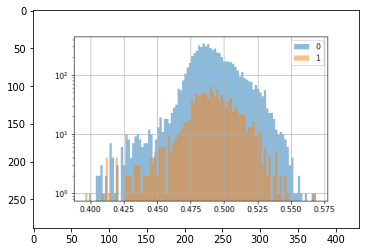

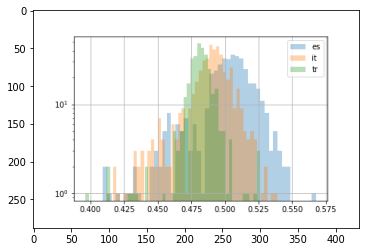

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('valid_hist.png')
_ = plt.imshow(img)
plt.show()
img = mpimg.imread('valid_toxic_hist.png')
_ = plt.imshow(img)